In [ ]:
import pandas as pd
import transformers
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from torchvision.utils import make_grid
from torchvision.models import inception_v3, Inception_V3_Weights
from scipy import linalg


In [2]:
# mount drive to save stuff
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# will check and use MPS if available, otherwise CUDA, otherwise CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA (GPU) - {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

Using device: CUDA (GPU) - NVIDIA A100-SXM4-40GB


In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
# For downloading entire datasets, install the kaggle API client:
!pip install kaggle

import kagglehub
from kagglehub import KaggleDatasetAdapter

# --------- Run once ---------
# 1. Go to your Kaggle profile: https://www.kaggle.com/<your-username>/account
# 2. Under 'API', click 'Create New API Token' to download `kaggle.json`.
# 3. Upload `kaggle.json` to your Colab environment (e.g., File -> Upload to session storage).
# 4. Run the following commands in a separate cell or uncomment and run them here:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# -----------------------------------------------------

import kaggle

# Download the entire dataset to a local directory and unzip it
dataset_name = "ashery/chexpert"
download_path = "./CheXpert-v1.0-small"
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset '{dataset_name}' downloaded to: {download_path}")
print("Files in the downloaded dataset:")
!ls -F {download_path}

Dataset URL: https://www.kaggle.com/datasets/ashery/chexpert
Dataset 'ashery/chexpert' downloaded to: ./CheXpert-v1.0-small
Files in the downloaded dataset:
train/	train.csv  valid/  valid.csv


In [5]:
# Load in data
train_full = pd.read_csv("/content/CheXpert-v1.0-small/train.csv")
val_full = pd.read_csv("/content/CheXpert-v1.0-small/valid.csv")


In [ ]:
train_full.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [6]:
train_full = train_full.fillna(0)
val_full = val_full.fillna(0)

### Text Encoder

In [7]:
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"

In [8]:
class ClinicalTextEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(ClinicalTextEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(
            MODEL_NAME
        )
        self.proj = nn.Linear(768, embed_dim)

    def forward(self, token_ids, attention_masks):
        outputs = self.bert(token_ids, attention_mask=attention_masks)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings = self.proj(cls_embeddings)
        # normalizing because we need to compare with image embeddings later
        # for the contrastive similarity
        embeddings = F.normalize(embeddings, p=2, dim=-1, eps=1e-6)
        return embeddings

### GAN

In [9]:
def generate_report_updated(row):
    labels = row.iloc[5:]  # Skip Path, Sex, Age, Frontal/Lateral, AP/PA

    # Separate findings by certainty
    positive_findings = list(labels[labels == 1.0].index)
    uncertain_findings = list(labels[labels == -1.0].index)

    # Build the report
    report_parts = []

    # Add patient demographics for context
    age = int(row['Age']) if pd.notna(row['Age']) else None
    sex = row['Sex'].lower() if pd.notna(row['Sex']) else None
    view = row['Frontal/Lateral'].lower() if pd.notna(row['Frontal/Lateral']) else None

    # Start with view type
    if view:
        report_parts.append(f"{view.capitalize()} chest radiograph")
    else:
        report_parts.append("Chest radiograph")

    # Add demographics
    demo = []
    if age:
        demo.append(f"{age}-year-old")
    if sex:
        demo.append(sex)
    if demo:
        report_parts.append(f"of {' '.join(demo)} patient")

    # Add findings
    if len(positive_findings) == 0 and len(uncertain_findings) == 0:
        report_parts.append("demonstrates no acute cardiopulmonary abnormality")
    else:
        findings_text = []

        # Definite findings
        if positive_findings:
            findings_clean = [f.lower().replace('_', ' ') for f in positive_findings]
            findings_text.append("shows " + ", ".join(findings_clean))

        # Uncertain findings (optional - you might want to treat these differently)
        if uncertain_findings:
            uncertain_clean = [f.lower().replace('_', ' ') for f in uncertain_findings]
            findings_text.append("possible " + ", ".join(uncertain_clean))

        report_parts.append(". ".join(findings_text))

    return " ".join(report_parts) + "."


In [10]:
# new dataset for image size
class CustomGANDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        df = df.reset_index(drop=True) # Reset index to ensure 0-based indexing
        # Text stuff
        self.text_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.reports = df.apply(
            generate_report_updated, axis=1
        )  # Maybe move generate report to inside the dataset idk

        # Vision stuff?
        self.images = df["Path"]
        self.transform = transforms.Compose(
        [
        transforms.Resize((128, 128)),          # changed from 256 to 128
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
          ),  # maps [0,1] -> [-1,1]
        ]
        )

    def __len__(self):
        return len(self.reports)  # This could work or we could do another way

    def __getitem__(self, idx):
        # Text part
        report = self.reports[idx]
        encoder = self.text_tokenizer.encode_plus(
            report,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Vision part
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(image)

        return {
            "token_ids": encoder["input_ids"],
            "attention_masks": encoder["attention_mask"],
            "image_tensor": img_tensor,
        }  # Is vision part correct?

In [11]:
# Create train & val datasets
train_gandataset = CustomGANDataset(train_full)
val_gandataset = CustomGANDataset(val_full)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [12]:
# Create data loaders
train_ganloader = DataLoader(train_gandataset, batch_size=32, shuffle=False)
val_ganloader = DataLoader(val_gandataset, batch_size=32, shuffle=False)

In [13]:
text_enc = ClinicalTextEncoder(embed_dim=512).to(device)

# Load the best encoder weights
best_path = "/content/drive/MyDrive/CXR_GAN_Models/checkpoint_iter_14000.pt"
state = torch.load(best_path, map_location = device)
text_enc.load_state_dict(state["text_enc"])

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

<All keys matched successfully>

In [14]:
# freezing text encoder

text_enc.eval()
for p in text_enc.parameters():
    p.requires_grad = False

In [15]:
# create generator
class Generator(nn.Module):
    def __init__(self, z_dim=128, t_dim=512):
        super().__init__()
        in_dim = z_dim + t_dim  # 640

        # start from 8x8
        self.fc = nn.Linear(in_dim, 512 * 8 * 8)

        self.main = nn.Sequential(
            # 512 x 8 x 8 -> 256 x 16 x 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 256 x 16 x 16 -> 128 x 32 x 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 128 x 32 x 32 -> 64 x 64 x 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64 x 64 x 64 -> 3 x 128 x 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),   # output in [-1, 1]
        )

    def forward(self, z_noise, e_text):
        cond = torch.cat([z_noise, e_text], dim=-1)      # [B, 640]
        x = self.fc(cond)                                # [B, 512*8*8]
        x = x.view(x.size(0), 512, 8, 8)                 # [B, 512, 8, 8]
        img = self.main(x)                               # [B, 3, 128, 128]
        return img


In [16]:
# create discriminator
class Discriminator(nn.Module):
    def __init__(self, t_dim=512):
        super().__init__()
        self.img_net = nn.Sequential(
            # 3 x 128 x 128 -> 64 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 x 64 x 64 -> 128 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 x 32 x 32 -> 256 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 x 16 x 16 -> 512 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # final feature map: [B, 512, 8, 8]
        self.fc_img = nn.Linear(512 * 8 * 8, 512)
        self.fc_joint = nn.Linear(512 + t_dim, 1)

    def forward(self, img, e_text):
        feat = self.img_net(img)                 # [B, 512, 8, 8]
        feat = feat.view(feat.size(0), -1)       # [B, 512*8*8]
        feat = self.fc_img(feat)                 # [B, 512]
        joint = torch.cat([feat, e_text], dim=-1)  # [B, 512 + t_dim]
        out = self.fc_joint(joint)               # [B, 1]
        return out


In [17]:
# Initialize generator and discriminator
generator = Generator(z_dim=128, t_dim = 512).to(device)
discriminator = Discriminator(t_dim=512).to(device)
adversarial_loss = torch.nn.BCELoss()

opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [ ]:
# training loop
num_epochs = 5
print_every = 2000
checkpoint_every = 5000

iteration=0
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    running_loss_G = []
    running_loss_D = []
    for batch in train_ganloader:
        real_imgs = batch["image_tensor"].to(device)  # [B,3,256,256]
        token_ids = batch["token_ids"].squeeze(1).to(device)
        attention_masks = batch["attention_masks"].squeeze(1).to(device)
        B = real_imgs.size(0)

        with torch.no_grad():
            e_text = text_enc(token_ids, attention_masks)  # [B,512]
        # !! generating random embeddings to test since encoder not trained yet
        #e_text = torch.randn(B, 512, device=device)

        z = torch.randn(B, 128, device=device)

        # --------------------
        # Train Discriminator
        # --------------------
        fake_imgs = generator(z, e_text).detach()
        real_logits = discriminator(real_imgs, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_D = 0.5 * (
            F.binary_cross_entropy_with_logits(real_logits, torch.ones_like(real_logits)) +
            F.binary_cross_entropy_with_logits(fake_logits, torch.zeros_like(fake_logits))
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --------------------
        # Train Generator
        # --------------------
        z = torch.randn(B, 128, device=device)
        fake_imgs = generator(z, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_G = F.binary_cross_entropy_with_logits(fake_logits, torch.ones_like(fake_logits))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        # Track losses
        running_loss_G.append(loss_G.item())
        running_loss_D.append(loss_D.item())

        # Print progress
        if iteration % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Iteration {iteration}")
            print(f"  Loss_D: {loss_D.item()}")
            print(f"  Loss_G: {loss_G.item()}")
            print(f"  Avg Loss_D: {np.mean(running_loss_D)}")
            print(f"  Avg Loss_G: {np.mean(running_loss_G)}")

        if iteration % checkpoint_every == 0 and iteration > 0:
            ckpt = {
                "epoch": epoch,
                "iteration": iteration,
                "G_state_dict": generator.state_dict(),
                "D_state_dict": discriminator.state_dict(),
                "opt_G_state_dict": opt_G.state_dict(),
                "opt_D_state_dict": opt_D.state_dict(),
            }
            torch.save(ckpt, f"/content/drive/MyDrive/CXR_GAN_Models/clinical_gan_{iteration}.pt")
            print(f"Saved checkpoint at iter {iteration}")
        iteration += 1

    print(f"Epoch {epoch+1} finished | Avg_D: {np.mean(running_loss_D):.4f}, Avg_G: {np.mean(running_loss_G):.4f}")



Epoch [1/5] Iteration 0
  Loss_D: 0.688086748123169
  Loss_G: 2.9577109813690186
  Avg Loss_D: 0.688086748123169
  Avg Loss_G: 2.9577109813690186
Epoch [1/5] Iteration 2000
  Loss_D: 0.10273454338312149
  Loss_G: 4.701498031616211
  Avg Loss_D: 0.3672944097037189
  Avg Loss_G: 5.128867822439074
Epoch [1/5] Iteration 4000
  Loss_D: 0.8453297019004822
  Loss_G: 0.6651269197463989
  Avg Loss_D: 0.3523577810561837
  Avg Loss_G: 4.414153340960856
Saved checkpoint at iter 5000
Epoch [1/5] Iteration 6000
  Loss_D: 0.16400064527988434
  Loss_G: 3.55511474609375
  Avg Loss_D: 0.34444627877360967
  Avg Loss_G: 4.1828018065018275
Epoch 1 finished | Avg_D: 0.3334, Avg_G: 4.1980
Epoch [2/5] Iteration 8000
  Loss_D: 0.26288262009620667
  Loss_G: 7.788745880126953
  Avg Loss_D: 0.2840328588167807
  Avg Loss_G: 4.078852698568829
Epoch [2/5] Iteration 10000
  Loss_D: 0.2189052402973175
  Loss_G: 5.638441562652588
  Avg Loss_D: 0.2693499583206792
  Avg Loss_G: 4.220153365621073
Saved checkpoint at iter 

In [ ]:
save_dir = "/content/drive/MyDrive/CXR_GAN_Models"
os.makedirs(save_dir, exist_ok=True)

print("Saving to:", save_dir)


Saving to: /content/drive/MyDrive/CXR_GAN_Models


In [ ]:
# save final models
G_path = os.path.join(save_dir, "final_clinical_generator.pt")
D_path = os.path.join(save_dir, "final_clinical_discriminator.pt")

torch.save(generator.state_dict(), G_path)
torch.save(discriminator.state_dict(), D_path)

print("Models saved to Google Drive.")


Models saved to Google Drive.


In [26]:
# read in saved model
generator = Generator(z_dim=128, t_dim=512).to(device)
discriminator = Discriminator(t_dim=512).to(device)

opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
# read previous checkpoint to see if better performance
ckpt_path = "/content/drive/MyDrive/CXR_GAN_Models/clinical_gan_30000.pt"
ckpt = torch.load(ckpt_path, map_location=device)
generator.load_state_dict(ckpt["G_state_dict"])
discriminator.load_state_dict(ckpt["D_state_dict"])


<All keys matched successfully>

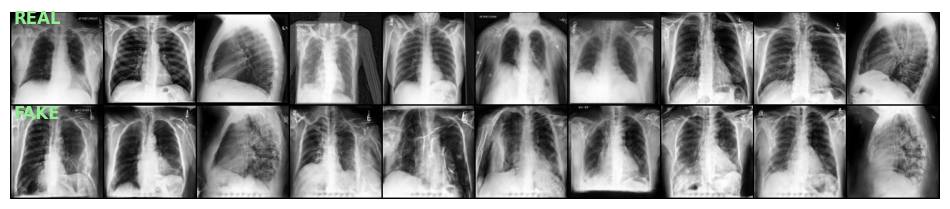

In [27]:
# set to eval mode
generator.eval()
text_enc.eval()

batch = next(iter(val_ganloader))

# Move to device
real_imgs = batch["image_tensor"].to(device)          # [B, 3, 128, 128]
token_ids = batch["token_ids"].squeeze(1).to(device)  # [B, 512]
attention_masks = batch["attention_masks"].squeeze(1).to(device)

# use the first N samples from this batch
N = 10
real_imgs = real_imgs[:N]
token_ids = token_ids[:N]
attention_masks = attention_masks[:N]

with torch.no_grad():
    # 1) Get text embeddings from trained text encoder
    e_text = text_enc(token_ids, attention_masks)      # [N, 512]

    # 2) Sample noise with matching batch size
    z = torch.randn(N, 128, device=device)            # [N, 128]

    # 3) Generate fake images conditioned on text
    samples = generator(z, e_text)                    # [-1, 1], [N, 3, 128, 128]

    # 4) Undo tanh normalization: [-1,1] -> [0,1]
    samples = (samples + 1) / 2
    real_imgs = (real_imgs + 1) / 2
    both = torch.cat([real_imgs, samples], dim=0)  # real_imgs must also be in [0,1] to display nicely
grid = make_grid(both, nrow=N)
plt.figure(figsize=(12, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# Add labels
plt.text(5, 16, "REAL", color="lightgreen", fontsize=12, weight="bold")
plt.text(5, 16 + 128 + 5, "FAKE", color="lightgreen", fontsize=12, weight="bold")
plt.axis("off")
plt.show()




#### FID

In [ ]:
# Load pretrained InceptionV3 for FID
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights, transform_input=False, aux_logits=True)
inception.fc = nn.Identity()   # so output is 2048-d features, not logits
inception.eval().to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 243MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [21]:
# setting correct dims
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def get_inception_acts(imgs):
    """
    imgs: [B, 3, H, W] in [-1,1]
    returns: [B, 2048] activations
    """
    # [-1,1] -> [0,1]
    imgs = (imgs + 1) / 2

    # Resize to 299x299
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)

    # Normalize to ImageNet stats
    imgs = (imgs - IMAGENET_MEAN) / IMAGENET_STD

    with torch.no_grad():
        acts = inception(imgs)   # [B, 2048]
    return acts


In [22]:
# get n real images
def get_acts_real(real_loader, n_samples=10000):
    acts = []
    count = 0
    for batch in real_loader:
        imgs = batch["image_tensor"].to(device)  # [-1,1], [B,3,128,128]
        a = get_inception_acts(imgs)
        acts.append(a.cpu().numpy())
        count += a.size(0)
        if count >= n_samples:
            break
    acts = np.concatenate(acts, axis=0)
    return acts[:n_samples]


In [23]:
# generate n fake images
def get_acts_fake(
    G,
    text_enc,
    loader,
    n_samples=1000,
    z_dim=128,
    device="cuda",
):
    acts = []
    count = 0

    G.eval()
    text_enc.eval()

    with torch.no_grad():
        for batch in loader:
            # 1) get text embeddings for this batch
            token_ids = batch["token_ids"].squeeze(1).to(device)
            attention_masks = batch["attention_masks"].squeeze(1).to(device)

            e_text = text_enc(token_ids, attention_masks)   # [B, 512]
            B = e_text.size(0)

            # maybe we only need part of this batch if we're near n_samples
            curr_bs = min(B, n_samples - count)
            e_text = e_text[:curr_bs]

            # 2) sample noise
            z = torch.randn(curr_bs, z_dim, device=device)

            # 3) generate fake images conditioned on real text embeddings
            fake_imgs = G(z, e_text)        # [-1, 1]

            # 4) get Inception activations
            a = get_inception_acts(fake_imgs)   # [curr_bs, 2048]
            acts.append(a.cpu().numpy())

            count += curr_bs
            if count >= n_samples:
                break

    acts = np.concatenate(acts, axis=0)
    return acts[:n_samples]


In [ ]:
# get mean and sd
def compute_mu_sigma(acts):
    mu = np.mean(acts, axis=0)
    sigma = np.cov(acts, rowvar=False)
    return mu, sigma
# calculate fid
def fid_from_acts(acts_r, acts_f):
    mu_r, sig_r = compute_mu_sigma(acts_r)
    mu_f, sig_f = compute_mu_sigma(acts_f)

    diff = mu_r - mu_f
    covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)

    # numerical issues: imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sig_r + sig_f - 2 * covmean)
    return float(fid)


In [28]:
# use 50000 real and 50000 fake images on val
n_samples = 50000
# get images
acts_real = get_acts_real(val_ganloader, n_samples=n_samples)
acts_fake = get_acts_fake(generator, text_enc, val_ganloader, n_samples=n_samples)

# calculate fid between
fid_score = fid_from_acts(acts_real, acts_fake)
print("FID:", fid_score)


/tmp/ipython-input-1897880018.py:14: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)


FID: 97.33026169512927


In [29]:
# use 50000 real and 50000 fake images from train
n_samples = 50000
# get images
acts_real = get_acts_real(train_ganloader, n_samples=n_samples)
acts_fake = get_acts_fake(generator, text_enc, train_ganloader, n_samples=n_samples)

# calculate fid between
fid_score = fid_from_acts(acts_real, acts_fake)
print("FID:", fid_score)

FID: 47.621680580587466


/tmp/ipython-input-1897880018.py:14: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)
